# Introduction #

In the previous lesson we looked at our first model-based method for feature engineering: clustering. In this lesson we look at our next: principal component analysis (PCA). Just like clustering is a partitioning of the dataset based on proximity, you could think of PCA as a partitioning of the variation in the data. PCA is a great tool to help you discover important relationships in the data and can also be used to create more informative features.

(Technical note: PCA is typically applied to [standardized](https://www.kaggle.com/alexisbcook/scaling-and-normalization) data. With standardized data "variation" means "correlation". With unstandardized data "variation" means "covariance". All data in this course will be standardized before applying PCA.)

# Principal Component Analysis #

In the [*Abalone*](https://www.kaggle.com/rodolfomendes/abalone-dataset) dataset are physical measurements taken from several thousand Tasmanian abalone. (An abalone is a sea creature much like a clam or an oyster.) We'll just look at a couple features for now: the `'Height'` and `'Diameter'` of their shells.

You could imagine that within this data are "axes of variation" that describe the ways the abalone tend to differ from one another. Pictorially, these axes appear as perpendicular lines running along the natural dimensions of the data, one axis for each original feature.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/rr8NCDy.png" width=300, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

Often, we can give names to these axes of variation. The longer axis we might call the "Size" component: small height and small diameter (lower left) contrasted with large height and large diameter (upper right). The shorter axis we might call the "Shape" component: small height and large diameter (flat shape) contrasted with large height and small diameter (round shape).

Notice that instead of describing abalones by their `'Height'` and `'Diameter'`, we could just as well describe them by their `'Size'` and `'Shape'`. This, in fact, is the whole idea of PCA: instead of describing the data with the original features, we describe it with its axes of variation. The axes of variation become the new features.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/XQlRD1q.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>The principal components become the new features by a rotation of the dataset in the feature space.
</center></figcaption>
</figure>

The new features PCA constructs are actually just linear combinations (weighted sums) of the original features:

```
df["Size"] = 0.707 * X["Height"] + 0.707 * X["Diameter"]
df["Shape"] = 0.707 * X["Height"] - 0.707 * X["Diameter"]
```

These new features are called the **principal components** of the data. The weights themselves are called **loadings**. There will be as many principal components as there are features in the original dataset: if we had used ten features instead of two, we would have ended up with ten components.

A component's loadings tell us what variation it expresses through signs and magnitudes:

| Features \ Components | Size (PC1) | Shape (PC2) |
|-----------------------|------------|-------------|
| Height                | 0.707      | 0.707       |
| Diameter              | 0.707      | -0.707      |

This table of loadings is telling us that in the `Size` component, `Height` and `Diameter` vary in the same direction (same sign), but in the `Shape` component they vary in opposite directions (opposite sign). In each component, the loadings are all of the same magnitude and so the features contribute equally in both.

PCA also tells us the *amount* of variation in each component. We can see from the figures that there is more variation in the data along the `Size` component than along the `Shape` component. PCA makes this precise through each component's **percent of explained variance**.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/xWTvqDA.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center> Size accounts for about 96% and the Shape for about 4% of the variance between Height and Diameter.
</center></figcaption>
</figure>

The `Size` component captures the majority of the variation between `Height` and `Diameter`. It's important to remember, however, that the amount of variance in a component doesn't necessarily correspond to how good it is as a predictor: it depends on what you're trying to predict.

# PCA for Feature Engineering #

There are two ways you could use PCA for feature engineering.

The first way is to use it as a descriptive technique. Since the components tell you about the variation, you could compute the MI scores for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create -- a product of `'Height'` and `'Diameter'` if `'Size'` is important, say, or a ratio of `'Height'` and `'Diameter'` if `Shape` is important. You could even try clustering on one or more of the high-scoring components.

The second way is to use the components themselves as features. Because the components expose the variational structure of the data directly, they can often be more informative than the original features. Here are some use-cases:
- **Dimensionality reduction**: When your features are highly redundant (*multicollinear*, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.
- **Anomaly detection**: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.
- **Noise reduction**: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
- **Decorrelation**: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.

PCA basically gives you direct access to the correlational structure of your data. You'll no doubt come up with applications of your own!

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>PCA Best Practices</strong><br>
There are a few things to keep in mind when applying PCA:
<ul>
<li> PCA only works with numeric features, like continuous quantities or counts.
<li> PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have good reason not to.
<li> Consider removing or constraining outliers, since they can have an undue influence on the results.
</ul>
</blockquote>

# Example - 1985 Automobiles #

In this example, we'll return to our [*Automobile*](https://www.kaggle.com/toramky/automobile-dataset) dataset and apply PCA, using it as a descriptive technique to discover features. We'll look at other use-cases in the exercise.

This hidden cell loads the data and defines the functions `plot_variance` and `make_mi_scores`.

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("../input/fe-course-data/autos.csv")

We've selected four features that cover a range of properties. Each of these features also has a high MI score with the target, `price`. We'll standardize the data since these features aren't naturally on the same scale.

In [2]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

Now we can fit scikit-learn's `PCA` estimator and create the principal components. You can see here the first few rows of the transformed dataset.

In [3]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


After fitting, the `PCA` instance contains the loadings in its `components_` attribute. (Terminology for PCA is inconsistent, unfortunately. We're following the convention that calls the transformed columns in `X_pca` the *components*, which otherwise don't have a name.) We'll wrap the loadings up in a dataframe.

In [4]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


Recall that the signs and magnitudes of a component's loadings tell us what kind of variation it's captured. The first component (`PC1`) shows a contrast between large, powerful vehicles with poor gas milage, and smaller, more economical vehicles with good gas milage. We might call this the "Luxury/Economy" axis. The next figure shows that our four chosen features mostly vary along the Luxury/Economy axis.

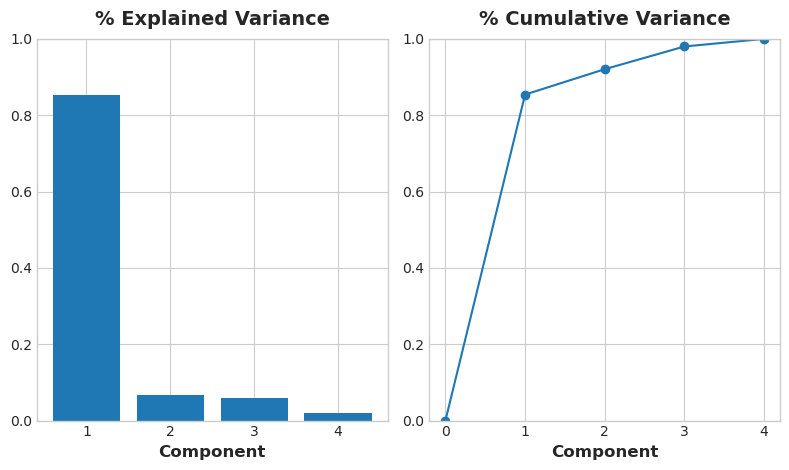

In [5]:
# Look at explained variance
plot_variance(pca);

Let's also look at the MI scores of the components. Not surprisingly, `PC1` is highly informative, though the remaining components, despite their small variance, still have a significant relationship with `price`. Examining those components could be worthwhile to find relationships not captured by the main Luxury/Economy axis.

In [6]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.013264
PC2    0.379156
PC3    0.306703
PC4    0.203329
Name: MI Scores, dtype: float64

The third component shows a contrast between `horsepower` and `curb_weight` -- sports cars vs. wagons, it seems.

In [7]:
# Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
df.loc[idx, cols]

,make,body_style,horsepower,curb_weight
118,porsche,hardtop,207,2756
117,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


To express this contrast, let's create a new ratio feature:

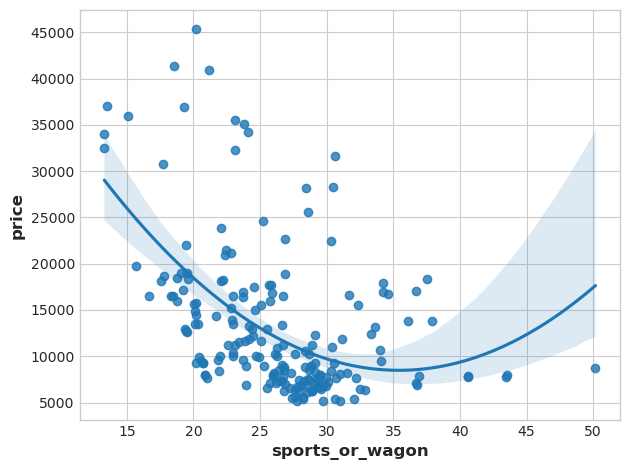

In [8]:
df["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2);

# Your Turn #

[**Improve your feature set**](https://www.kaggle.com/kernels/fork/14393921) by decomposing the variation in *Ames Housing* and use principal components to detect outliers.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*